In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.ensemble import RandomForestRegressor

## Multiprocessing

This adds a magic line %job which allows for cells to be run in their own threads.

In [3]:
import ctypes

def jobs_manager():
    from IPython.lib.backgroundjobs import BackgroundJobManager
    from IPython.core.magic import register_line_magic
    from IPython import get_ipython

    jobs = BackgroundJobManager()

    @register_line_magic
    def job(line):
        ip = get_ipython()
        jobs.new(line, ip.user_global_ns)

    return jobs

def kill_job(thread):
    id = thread.ident

    code = ctypes.pythonapi.PyThreadState_SetAsyncExc(
        ctypes.c_long(id),
        ctypes.py_object(SystemError))

    if code == 0:
        raise ValueError('invalid thread id')

    elif code != 1:
        ctypes.pythonapi.PyThreadState_SetAsyncExc(
            ctypes.c_long(id),
            ctypes.c_long(0))

        raise SystemError('PyThreadState_SetAsyncExc failed')
        
jobs = jobs_manager()

In [4]:
%job print('hello_world') # Print hello in a new thread

hello_world


In [5]:
jobs.status()

Completed jobs:
0 : print('hello_world') # Print hello in a new thread



In [6]:
# Train a model in a new thread
model = RandomForestRegressor(n_estimators=100)

In [7]:
# Create a data set of sin + gaussian white noise
X = np.arange(0, 8, 0.01)
Y = np.sin(X) + np.random.normal(scale=0.1, size=len(X))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# Correct the shape of the input data
X_train, X_test, Y_train, Y_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1), Y_train.reshape(-1, 1), Y_test.reshape(-1, 1)

In [9]:
# Fit the model in a seperate thread
%job model.fit(X_train, Y_train) # Print hello in a new thread

In [10]:
# Check the status of the training
jobs.status()

Running jobs:
2 : model.fit(X_train, Y_train) # Print hello in a new thread

Completed jobs:
0 : print('hello_world') # Print hello in a new thread



The training was successful as the job is complete.

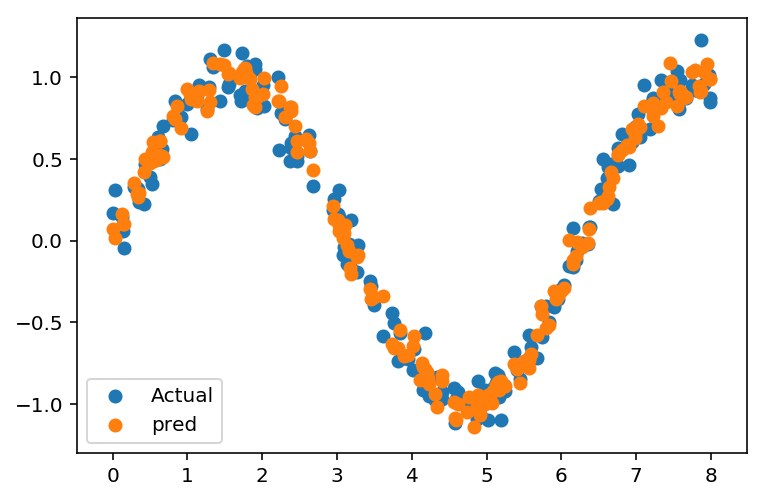

In [11]:
# Results
plt.scatter(X_test, Y_test)
plt.scatter(X_test, model.predict(X_test))
plt.legend(['Actual', 'pred'])

### Failed job debugging

This is an example of debugging when a job fails. The traceback can be easily seen.

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [13]:
%job model.fit(X_train, Y_train) # Print hello in a new thread

In [14]:
jobs.status()

Completed jobs:
0 : print('hello_world') # Print hello in a new thread
2 : model.fit(X_train, Y_train) # Print hello in a new thread

Dead jobs:
3 : model.fit(X_train, Y_train) # Print hello in a new thread



The training failed as indicated by a dead job.<br>

The trace can be easily seen by the following.

In [15]:
# Check the traceback of a failed job
jobs.traceback(3) #the arg is the id of the dead job

None


### Killing a job

In [16]:
# Create a very large model
model = RandomForestRegressor(n_estimators=100000)

In [17]:
from sklearn.model_selection import train_test_split

X = np.random.normal(size=(800,200)) # np.hstack([X.reshape(800, 1)] * 100)

# Create a dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [18]:
%job model.fit(X_train, Y_train) # Unending job

In [19]:
jobs.status()

Running jobs:
4 : model.fit(X_train, Y_train) # Unending job

Completed jobs:
0 : print('hello_world') # Print hello in a new thread
2 : model.fit(X_train, Y_train) # Print hello in a new thread

Dead jobs:
3 : model.fit(X_train, Y_train) # Print hello in a new thread



The job will be running for a very long time.

In [20]:
# Jobs can be killed based on their id
kill_job(jobs.all[4])

In [21]:
jobs.status()

Completed jobs:
0 : print('hello_world') # Print hello in a new thread
2 : model.fit(X_train, Y_train) # Print hello in a new thread

Dead jobs:
3 : model.fit(X_train, Y_train) # Print hello in a new thread
4 : model.fit(X_train, Y_train) # Unending job



Job 4 has been killed and is now a dead job.